In [13]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),       
     ('order_items.csv', 'order_items') #added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Upsc@2025',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "C:/Users/LENOVO/Downloads/ecommerce"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector 

db = mysql.connector.connect(host='localhost',
    user='root',
    password='Upsc@2025',
    database='ecommerce')

cur = db.cursor()

 # List all unique cities where customers are located.

In [82]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [37]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [58]:
query = """
SELECT UPPER(products.product_category) AS category, 
       ROUND(SUM(payments.payment_value), 2) AS sales
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category
"""


cur.execute(query)


data = cur.fetchall()


df = pd.DataFrame(data, columns=["category", "sales"])
df


,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [50]:
query = """  select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments", data[0][0]


('the percentage of orders that were paid in installments', Decimal('99.9981'))

# Count the number of customers from each state.

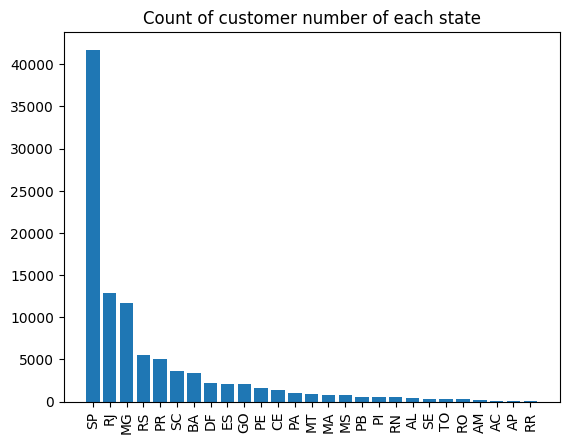

In [97]:
query = """  select customer_state,COUNT(customer_id)
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["State", "customer_count"])
df
df= df.sort_values(by = "customer_count", ascending = False)
plt.bar(df["State"],df["customer_count"])

plt.xticks(rotation=90)
plt.title("Count of customer number of each state")
plt.show()

 # Calculate the number of orders per month in 2018.

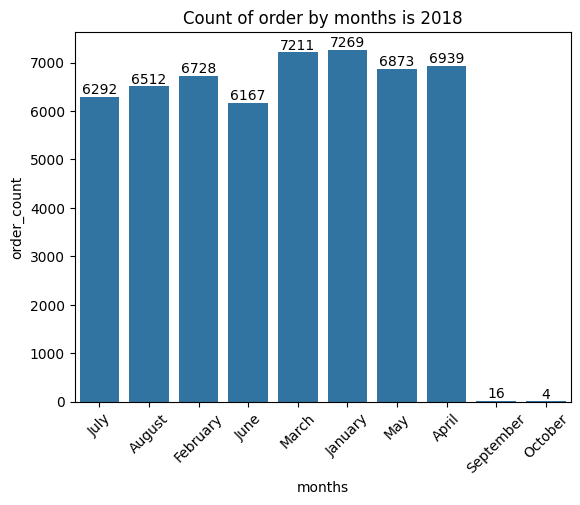

In [98]:
query = """  select monthname(order_purchase_timestamp) as  months , count(order_id)as order_count
from orders where year (order_purchase_timestamp) = 2018 
group by months 
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["months", "order_count"])

ax = sns.barplot(x= df["months"], y = df ["order_count"],data = df)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of order by months is 2018")

plt.show()



# Find the average number of products per order, grouped by customer city.

In [142]:
query = """with count_per_order as
(select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
""" 

cur.execute(query)

data = cur.fetchall()
df= pd.DataFrame(data)
df.head(5)

,0,1
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


# Calculate the percentage of total revenue contributed by each product category.

In [175]:
query = """SELECT UPPER(products.product_category) AS category, 
  round((SUM(payments.payment_value)/(select SUM(payment_value) from payments))*100,2) as sales_percentage
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales_percentage desc"""



cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category" , "sales_percentage"])
df.head(5)

,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector 

db = mysql.connector.connect(host='localhost',
    user='root',
    password='Upsc@2025',
    database='ecommerce')

cur = db.cursor()


In [183]:
import numpy as np
query =""" select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2) as price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","order_count","price"])
df.head()

arr1 = df["order_count"]
arr2 = df["price"]

a= np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])
      


the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

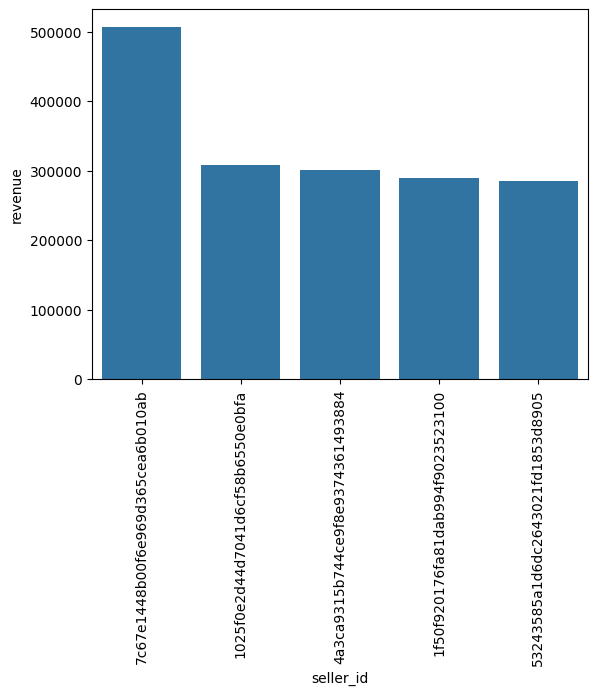

In [196]:
query = """ select *,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id= payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id",y = "revenue",data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [200]:
query = """select customer_id,order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment 
from payments join orders
on orders.order_id = payments.order_id) as a """

cur.execute(query)

data = cur.fetchall()
df= pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp","payment","mov_avg"])
df.head()

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [19]:

query = """select years,months,sum(payment)
over(order by years , months) cumulative_sales
from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id= payments.order_id
group by years , months order by years, months) as a 
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "months","cumulative_sales"])
df

,years,months,cumulative_sales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


 # Calculate the year-over-year growth rate of total sales.

In [33]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id= payments.order_id
group by years order by years)
select years , ((payment - lag(payment,1)  over(order by years))/
lag(payment,1) over(order by years ))*100 from a ;
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


 # Identify the top 3 customers who spent the most money in each year.

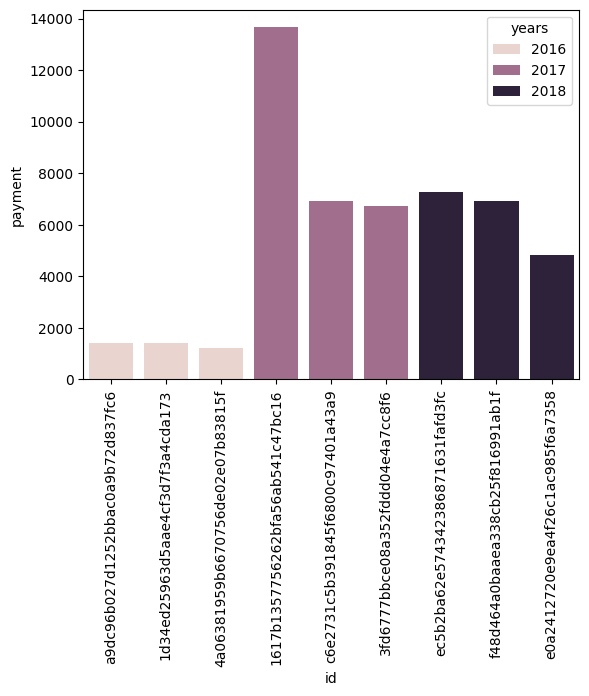

In [34]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()